# Dataset Description
The dataset contains data about users who hit the website: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).  

Columns:
* `country` : user country based on the IP address
* `age` : user age. Self-reported at sign-in step
* `new_user` : whether the user created the account during this session or had already an account and simply came back to the site
* `source` : marketing channel source:  
  1. Ads: came to the site by clicking on an advertisement
  2. Seo: came to the site by clicking on search results
  3. Direct: came to the site by directly typing the URL on the browser  
  
* `total_pages_visited`: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
* `converted`: this is the label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.

## 1. Exploratory Data Analysis
Before implementing any machine learning model, it's important to perform Exploratory Data Analysis(EDA):  
* I need to know the data through inspecting and visualization first, then I will be able to know how to preprocess the data for machine learning, and also gain insights on which machine learning models would be appropriate to solve the problems.   
* What's more, through the process of EDA, I can get insights into the operation of the business, which would be helpful for me to come up with advice on how to improve the operation.

In [1]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_palette('Set2')

In [2]:
# read the dataset as a pandas dataframe
data = pd.read_csv('https://raw.githubusercontent.com/JielingChen/optimizing_conversion_rate/main/conversion_data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
# find out how many sessions are in the dataset
len(data)

316200

Check the data type of each column and whether there is missing data or not:

In [4]:
# get information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


Inspect the summary statistics of the data:

In [5]:
# get the subset of the dataset which only contains numeric data and check summary statistics
data_num = data[['age', 'total_pages_visited', 'converted', 'new_user']]
data_num.describe()

,age,total_pages_visited,converted,new_user
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,4.872966,0.032258,0.685465
std,8.271802,3.341104,0.176685,0.464331
min,17.000000,1.000000,0.000000,0.000000
25%,24.000000,2.000000,0.000000,0.000000
50%,30.000000,4.000000,0.000000,1.000000
75%,36.000000,7.000000,0.000000,1.000000
max,123.000000,29.000000,1.000000,1.000000


* Only 3.2% of the users were converted.

In [6]:
# get the subset of the data set which only contains categorical data and check summary statistics
data_cat = data[['country', 'source']].astype('category')
data_cat.describe()

,country,source
count,316200,316200
unique,4,3
top,US,Seo
freq,178092,155040


In [7]:
# inspect the out-of-range data found in the age column
age_over_100 = data[data['age'] >= 100]
age_over_100

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


There are only two out-of-range data, so I can simply drop them.

In [8]:
# drop the out-of-range data
data = data[data['age'] < 100]
data_num = data_num[data_num['age'] < 100]

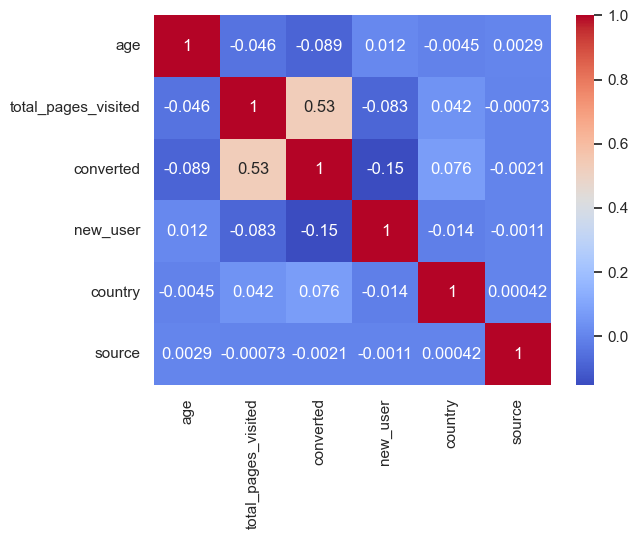

In [9]:
# encode the categorical variables and check the correlation between the variables
data_cat_encoded = data_cat.apply(lambda x: x.cat.codes)
data_encoded = pd.concat([data_num, data_cat_encoded], axis=1)
corr = data_encoded.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

* Conversion has the highest correlation with the total number of pages visited by a user during a session.
* Whether the user is a new user or not is the second impactful factor on conversion.

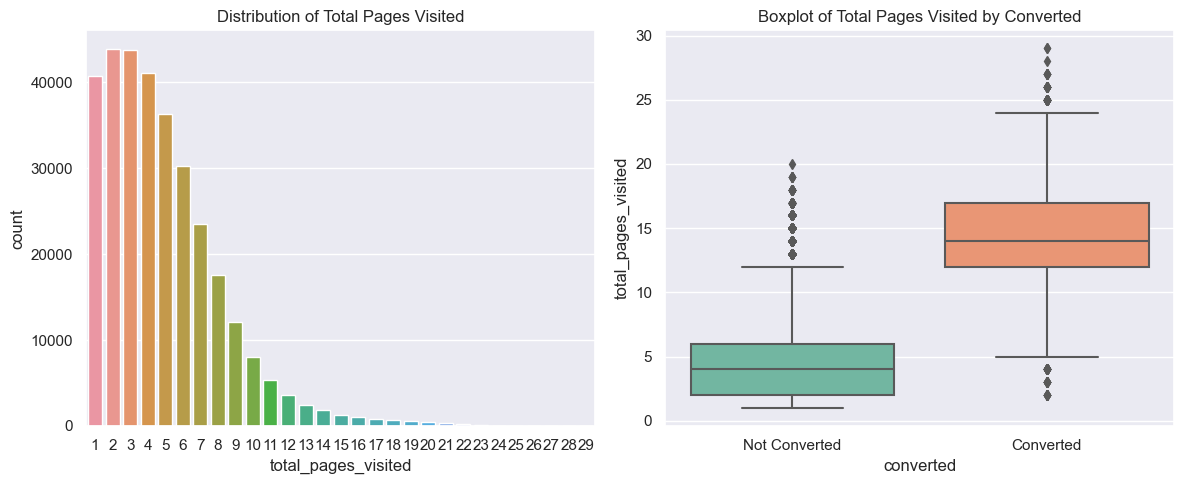

In [10]:
# check distribution of the total pages visited and boxplot of the total pages visited by converted
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(data=data, x='total_pages_visited', ax=axes[0])
axes[0].set_title('Distribution of Total Pages Visited')
sns.boxplot(data=data, x='converted', y='total_pages_visited', ax=axes[1])
axes[1].set_title('Boxplot of Total Pages Visited by Converted')
axes[1].set_xticklabels(['Not Converted', 'Converted'])

plt.tight_layout()
plt.show()

* Most users visited 1-9 pages.
* Converted users had more engagement than unconverted users. Most converted users visited 12-17 pages during their session.

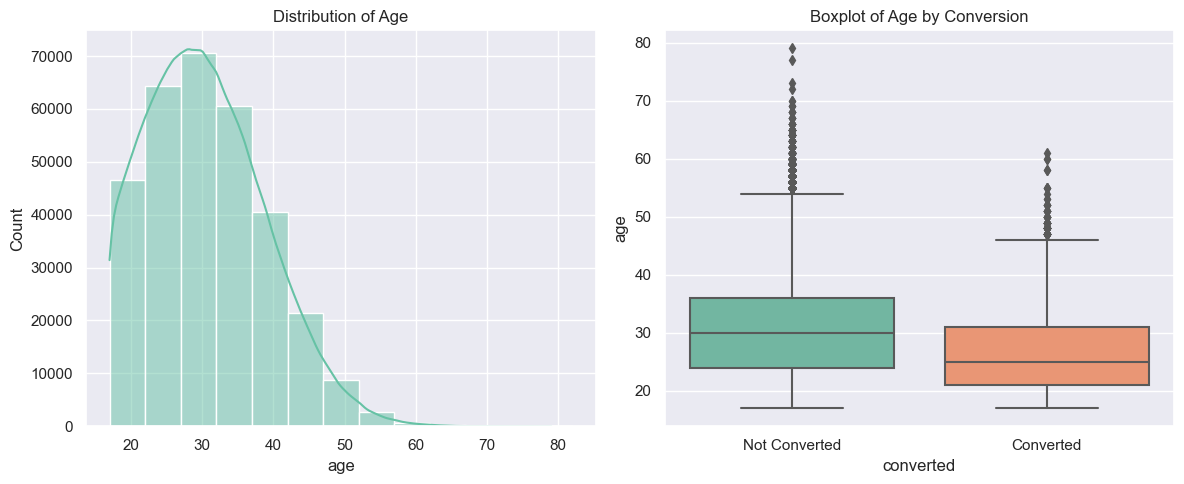

In [11]:
# check distribution of the age and boxplot of the age by conversion
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data['age'], kde=True, binwidth=5, ax=axes[0])
axes[0].set_title('Distribution of Age')
sns.boxplot(x='converted', y='age', data=data, ax=axes[1])
axes[1].set_title('Boxplot of Age by Conversion')
axes[1].set_xticklabels(['Not Converted', 'Converted'])

plt.tight_layout()
plt.show()

* Most of the users were between 20 and 40 years old.
* Converted users tended to be younger than unconverted users.

In [12]:
# convert age into age groups
age_group = pd.cut(data['age'], bins=[0, 20, 30, 40, 50, 90])
data['age_group'] = age_group
data.head()

,country,age,new_user,source,total_pages_visited,converted,age_group
0,UK,25,1,Ads,1,0,"(20, 30]"
1,US,23,1,Seo,5,0,"(20, 30]"
2,US,28,1,Seo,4,0,"(20, 30]"
3,China,39,1,Seo,5,0,"(30, 40]"
4,US,30,1,Seo,6,0,"(20, 30]"


In [13]:
# define a function to plot the pointplot and countplot
def plot_conversion(data, col):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # order the x-axis by numbers of users
    order = list(data[col].value_counts().index)
    
    # converted users stacked barplot
    converted_counts = data.groupby(col)['converted'].value_counts().unstack()
    converted_counts = converted_counts.reindex(order)
    converted_counts.plot(kind='bar', stacked=True, width=0.5, ax=axes[0])
    axes[0].set_title(f'User Distribution by {col.capitalize()}')
    axes[0].set_ylabel('Number of Users')
    axes[0].set_xticklabels(converted_counts.index, rotation=0)
    axes[0].legend(['Not Converted', 'Converted'])
    # add percentage annotations to the stacked barplot
    total_user_counts = len(data)
    percent_of_each_category = data[col].value_counts() / total_user_counts * 100
    # add percentage annotations at the top of each bar
    for i, percent in enumerate(percent_of_each_category):
        axes[0].annotate(f'{percent:.2f}%', xy=(i, total_user_counts * percent / 100 + 1000),
                         ha='center', fontsize=10)
    
    # conversion rate pointplot
    sns.pointplot(x=col, y='converted', data=data, order=order, errorbar=None, ax=axes[1])
    axes[1].set_title(f'Conversion Rate by {col.capitalize()}')
    axes[1].set_ylabel('Conversion Rate')
    # Add aggregated values to the pointplot
    means = data.groupby(col)['converted'].mean().reindex(order)
    for i, mean in enumerate(means):
        axes[1].annotate(f'{mean:.2%}', xy=(i, mean), xytext=(-17, 1),
                         textcoords='offset points', ha='center', fontsize=11, color='red')
    
    plt.tight_layout()
    plt.show()

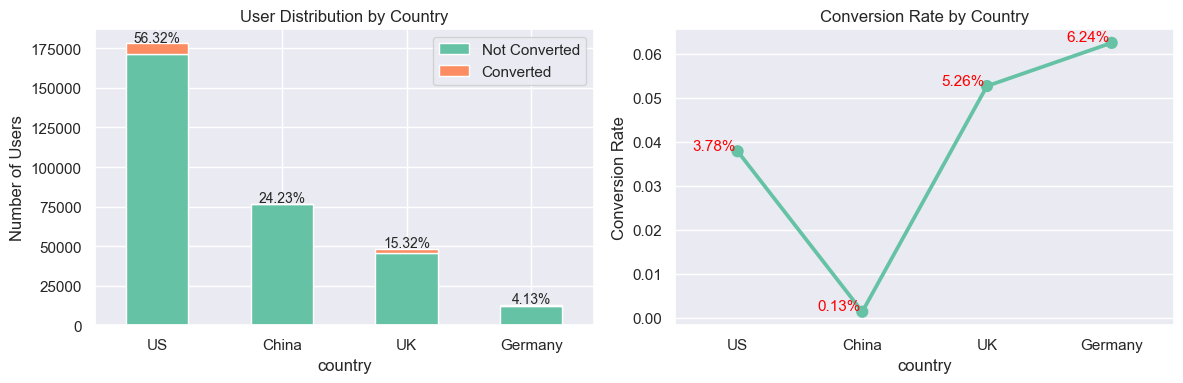

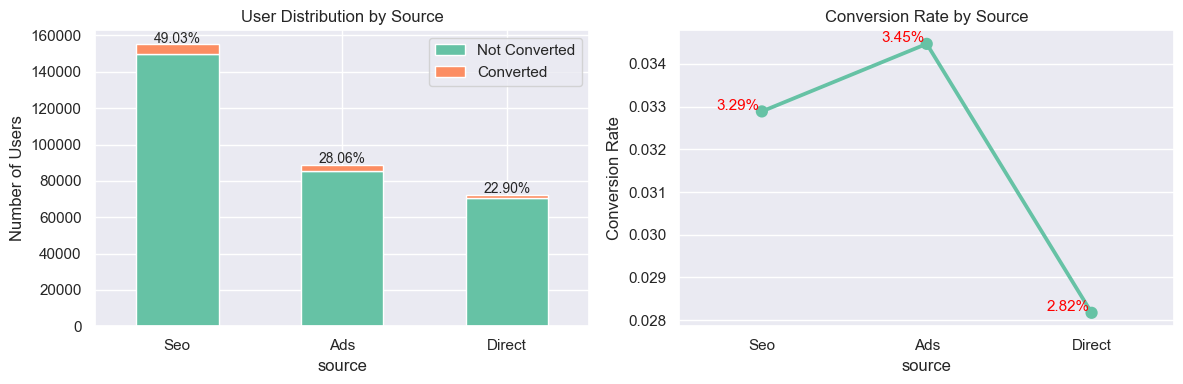

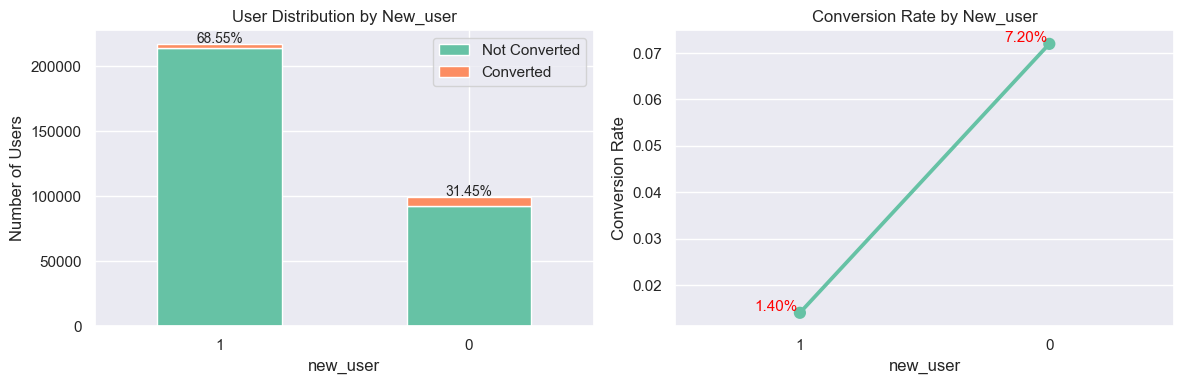

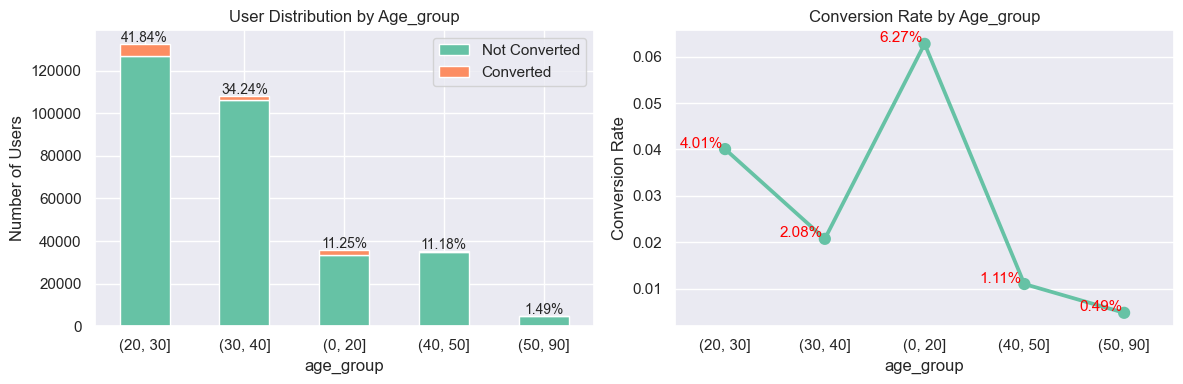

In [14]:
# plot the conversion by categorical variables
cat_var = ['country', 'source', 'new_user', 'age_group']
for var in cat_var:
    plot_conversion(data, var)

* Over 50% of the users were from the US, while Germany had the smallest user base. 
* Although the users from Germany were the least, Germany had the highest conversion rate.
* China had the second largest user base, but the conversion rate was significantly lower than the other 3 countries.
* Nearly 50% of the users came to our website by clicking on search results. Ads source has the highest conversion rate.
* Around 68% of the users are new user. The conversion rate of the old users was 7 times higher than that of new users.  
* Most of our users were aged 20 - 40 years old. Converted users tended to be younger than unconverted users.

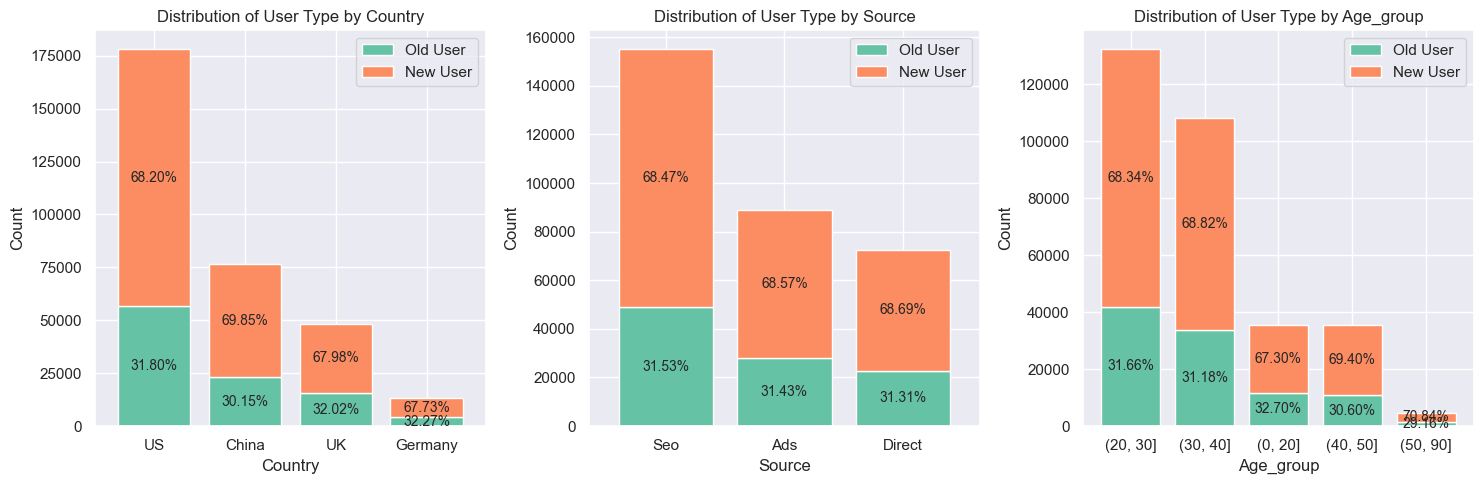

In [15]:
# plot the counts of user type by country, source and age group
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
var_new_user_stack = ['country', 'source', 'age_group']

for i, var in enumerate(var_new_user_stack):
    order = list(data[var].value_counts().index)
    new_user_by_var = data.groupby(var)['new_user'].value_counts().unstack()
    new_user_by_var = new_user_by_var.reindex(order)
    
    new_user_by_var.plot(kind='bar', stacked=True, ax=axes[i], width=0.8)
    axes[i].set_title(f'Distribution of User Type by {var.capitalize()}')
    axes[i].set_xlabel(var.capitalize())
    axes[i].set_ylabel('Count')
    axes[i].legend(['Old User', 'New User'])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0)
    
    # Add percentage annotations
    total_counts = new_user_by_var.sum(axis=1)
    new_user_by_var_percent = new_user_by_var.div(total_counts, axis=0) * 100
    
    bar_width = axes[i].patches[0].get_width()
    for j, patch in enumerate(axes[i].patches):
        x = patch.get_x() + bar_width / 2
        y = patch.get_y() + patch.get_height() / 2
        percent = f'{new_user_by_var_percent.iloc[j % len(order), j // len(order)]:.2f}%'
        axes[i].annotate(percent, (x, y), ha='center', va='center', fontsize=10)
    
plt.tight_layout()
plt.show()

* The distribution of user type from different countries, marketing channel sources and age groups is approximately same. In other words, these factors don't have impact on the types of users.

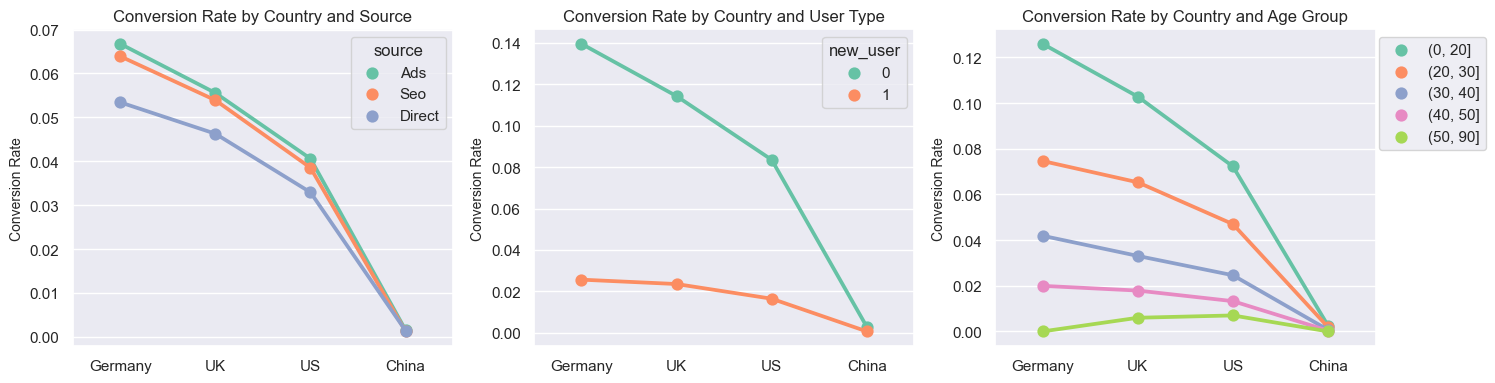

In [16]:
# plot conversion rate by country and source, country and user type, country and age group
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# order by conversion rate
order = list(data.groupby('country')['converted'].mean().sort_values(ascending=False).index)

sns.pointplot(x='country', y='converted', hue='source', data=data, ax=axes[0], errorbar=None, order=order)
axes[0].set_title('Conversion Rate by Country and Source')
axes[0].set_ylabel('Conversion Rate', fontsize=10)
axes[0].set_xlabel('')

sns.pointplot(x='country', y='converted', hue='new_user', data=data, ax=axes[1], errorbar=None, order=order)
axes[1].set_title('Conversion Rate by Country and User Type')
axes[1].set_ylabel('Conversion Rate', fontsize=10)
axes[1].set_xlabel('')

sns.pointplot(x='country', y='converted', hue='age_group', data=data, ax=axes[2], errorbar=None, order=order)
axes[2].set_title('Conversion Rate by Country and Age Group')
axes[2].set_ylabel('Conversion Rate', fontsize=10)
axes[2].legend(loc='upper right', bbox_to_anchor=(1.31, 1))
axes[2].set_xlabel('')

plt.tight_layout()
plt.show()

* In China, source, user type and age group don't have impact on the conversion rate. The low conversion rate of China might be contributed by other reasons.
* The conversion rates between old user and new user is most distinguished in Germany, indicating user type has the most impact in Germany.
* The conversion rates among age groups is most distinguished in Germany, with a very high conversion rate in the (0,20] age group. The (50, 90] age group has the highest conversion rate in the US. 

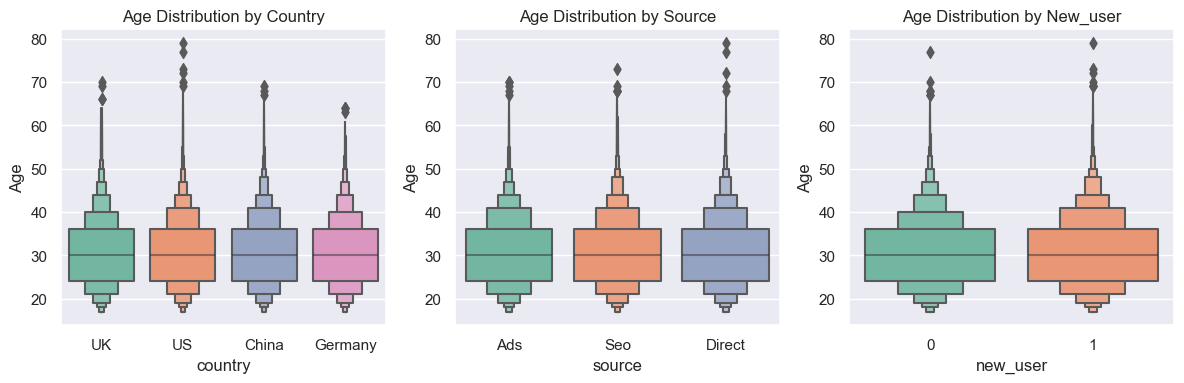

In [17]:
# plot the age distribution by categorical variables
boxen_var = ['country', 'source', 'new_user']
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, var in enumerate(boxen_var):
    sns.boxenplot(data=data, x=var, y='age', ax=axes[i])
    axes[i].set_title(f'Age Distribution by {var.capitalize()}')
    axes[i].set_ylabel('Age')

plt.tight_layout()
plt.show()

* The age structures among different contries, sources and user types are pretty much the same.

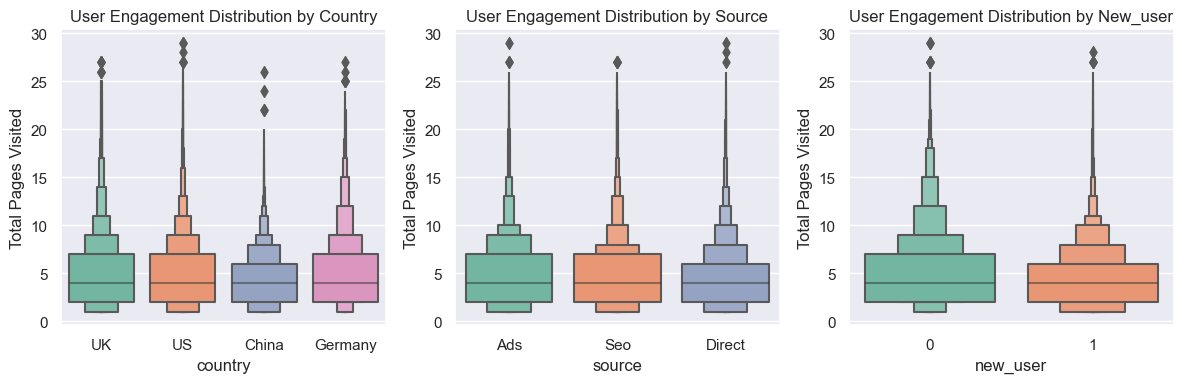

In [18]:
# plot the user engagement distribution by categorical variables
boxen_var = ['country', 'source', 'new_user']
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, var in enumerate(boxen_var):
    sns.boxenplot(data=data, x=var, y='total_pages_visited', ax=axes[i])
    axes[i].set_title(f'User Engagement Distribution by {var.capitalize()}')
    axes[i].set_ylabel('Total Pages Visited')

plt.tight_layout()
plt.show()

* The users in China has lower user engagement, and the other 3 countries don't show significant differences.
* The direct source has lower user engagement than the others.
* Old users have overall higher user engagement than the new users.

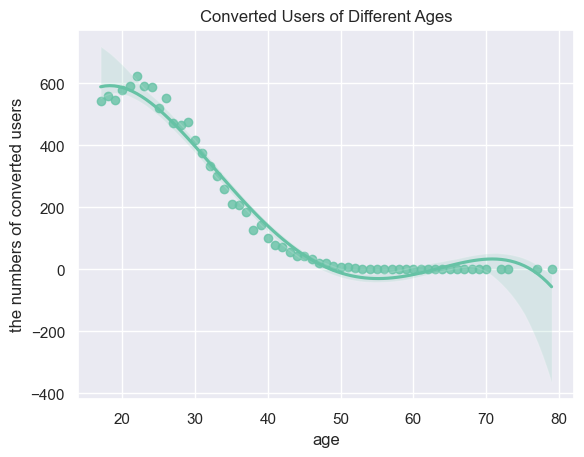

In [19]:
# create a regression plot showing the relationship between age and the number of converted users
convert_num_age = data.groupby('age')[['converted']].sum()
convert_num_age.reset_index(inplace=True)
sns.regplot(data=convert_num_age, x='age',  y='converted', order=4)
plt.ylabel('the numbers of converted users')
plt.title('Converted Users of Different Ages')
plt.show()

* The number of converted users declines as the user's age grow older. The users aged more than 50 don't convert.

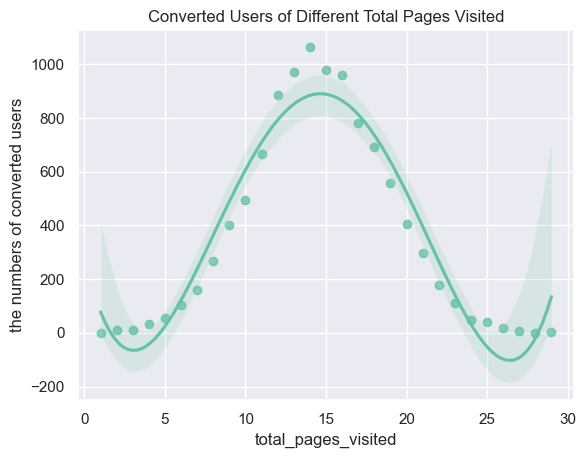

In [20]:
# create a regression plot showing the relationship between total_pages_visited and the number of converted users
convert_num_pages = data.groupby('total_pages_visited')[['converted']].sum()
convert_num_pages.reset_index(inplace=True)
sns.regplot(data=convert_num_pages, x='total_pages_visited',  y='converted', order=4)
plt.title('Converted Users of Different Total Pages Visited')
plt.ylabel('the numbers of converted users')
plt.show()

* Most users converted when visited 10-20 pages. 